In [ ]:
# %%

import pathlib
import glob
import os
import collections
import json
from omegaconf import OmegaConf

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')

import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from neuroformer.model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from neuroformer.trainer import Trainer, TrainerConfig
from neuroformer.utils import set_seed, update_object
from neuroformer.visualize import set_plot_params, set_plot_white
from neuroformer.SpikeVidUtils import round_n, set_intervals
set_plot_params()
# set_plot_white()

from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from scipy.ndimage import gaussian_filter, uniform_filter

parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"
import argparse

def parse_args():
    parser = argparse.ArgumentParser()
    # parser.add_argument("--infer", action="store_true", help="Inference mode")
    parser.add_argument("--train", action="store_true", default=False, help="Train mode")
    parser.add_argument("--dataset", type=str, default="first", help="Dataset")
    parser.add_argument("--dist", action="store_true", default=False, help="Distrinuted training")
    parser.add_argument("--resume", type=str, default=None, help="Resume from checkpoint")
    parser.add_argument("--rand_perm", action="store_true", default=False, help="Randomly permute the ID column")
    parser.add_argument("--mconf", type=str, default=None, help="Path to model config file")
    parser.add_argument("--downstream", action="store_true", default=False, help="Downstream task")
    parser.add_argument("--freeze_model", action="store_true", default=False, help="Freeze model")
    parser.add_argument("--title", type=str, default=None)
    parser.add_argument("--seed", type=int, default=25)
    parser.add_argument("--behavior", action="store_true", default=False, help="Behavior task")
    parser.add_argument("--predict_behavior", action="store_true", default=False, help="Predict behavior")
    # parser.add_argument("--behavior_vars", type=str, default=None, help="Behavior variables")
    parser.add_argument("--behavior_vars", nargs='+', default=None, help="Behavior variables")
    parser.add_argument("--round_vars", action="store_true", default=False, help="Round variables")
    parser.add_argument("--past_state", action="store_true", default=False, help="Input past state")
    parser.add_argument("--visual", action="store_true", default=False, help="Visualize")
    parser.add_argument("--contrastive", action="store_true", default=False, help="Contrastive")
    parser.add_argument("--local_rank", type=int, default=0)
    parser.add_argument("--fuse_stim_behavior", action="store_true", default=False, help="Fuse stimulus and behavior")
    return parser.parse_args()

# if __name__ == "__main__":
#     args = parse_args()
#     INFERENCE = not args.train
# else:
#     INFERENCE = True

# check if jupyter notebook

try:
    shell = get_ipython().__class__.__name__
    print("Running in Jupyter notebook")
    INFERENCE = True
    DATASET = "medial"
    DIST = False
    DOWNSTREAM = False
    RESUME = "./models/tensorboard/visnav_medial/behavior_pred_exp/classification/1/behavior_before_stim_RESUMEFalse_paststateTrue_method_behavior_True_['speed']_predictbehaviorFalse_roundedFalsevisualTrue_contrastiveTrue_['id', 'frames', 'behavior_mean', 'behavior_mean']/sparse_f:None_id:None/w:0.05_wp:0.25/6_Cont:False_window:0.05_f_window:0.3_df:0.005_blocksize:100_conv_True_shuffle:True_batch:224_sparse_(None_None)_blocksz446_pos_emb:False_temp_emb:True_drop:0.35_dt:True_2.0_52_max0.005_(8, 8, 8)_8_256.pt"
    RAND_PERM = False
    MCONF = "./models/tensorboard/visnav_medial/behavior_pred_exp/classification/1/behavior_before_stim_RESUMEFalse_paststateTrue_method_behavior_True_['speed']_predictbehaviorFalse_roundedFalsevisualTrue_contrastiveTrue_['id', 'frames', 'behavior_mean', 'behavior_mean']/sparse_f:None_id:None/w:0.05_wp:0.25/mconf.yaml"
    FREEZE_MODEL = False
    TITLE = None
    SEED = 25
    BEHAVIOR = True
    PREDICT_BEHAVIOR = False
    BEHAVIOR_VARS = ['speed']
    ROUND_VARS = False
    PAST_STATE = True
    VISUAL = True
    CONTRASTIVE = True
    FUSE_STIM_BEHAVIOR = False
except:
    print("Running in terminal")
    args = parse_args()
    INFERENCE = not args.train
    DATASET = args.dataset
    DIST = args.dist
    DOWNSTREAM = args.downstream
    RESUME = args.resume
    RAND_PERM = args.rand_perm
    MCONF = args.mconf
    FREEZE_MODEL = args.freeze_model
    TITLE = args.title
    SEED = args.seed
    BEHAVIOR = args.behavior
    PREDICT_BEHAVIOR = args.predict_behavior
    BEHAVIOR_VARS = args.behavior_vars
    ROUND_VARS = args.round_vars
    PAST_STATE = args.past_state
    VISUAL = args.visual
    CONTRASTIVE = args.contrastive
    FUSE_STIM_BEHAVIOR = args.fuse_stim_behavior

set_seed(25)

print(f" // CONTRASTIVE: {CONTRASTIVE} //")
print(f" // VISUAL: {VISUAL} //")
print(f" // PAST_STATE: {PAST_STATE} //")
print(f" // PREDICT_BEHAVIOR: {PREDICT_BEHAVIOR} //")
print(f" // BEHAVIOR: {BEHAVIOR} //")
print(f" // FUSE_STIM_BEHAVIOR: {FUSE_STIM_BEHAVIOR} //")

# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)



# %%
from neuroformer.prepare_data import DataLinks

ds = "LateralVRDataset"
ds = "MedialVRDataset"
ds = "VisNav_VR_Expt"
data_dir = f"data/VisNav_VR_Expt/"
DATA_POINTERS = getattr(DataLinks, ds)

if not os.path.exists(data_dir):
    print("Downloading data...")
    import gdown
    url = DATA_POINTERS['url']
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output=DATA_POINTERS['DIRECTORY'])



# %%
# load config files
import yaml

# base_path = "configs/visnav/predict_behavior"
base_path = "./models/tensorboard/visnav_medial" if MCONF is None else os.path.dirname(MCONF)

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)



# %%
import mat73

# data_path = DATA_POINTERS['RESPONSE_PATH']
if DATASET in ["first", "visnav"]:
    data_path = "./data/VisNav_VR_Expt"
elif DATASET == "medial":
    data_path = "./data/VisNav_VR_Expt/MedialVRDataset/"
elif DATASET == "lateral":
    data_path = "./data/VisNav_VR_Expt/LateralVRDataset"

print(f"Loading data from {data_path}")
# stimulus = np.load(os.path.join(data_path, "stimulus.npy"), allow_pickle=True)
# response = np.load(os.path.join(data_path, "response.npy"), allow_pickle=True)
# trial_data = np.load(os.path.join(data_path, "trial_data.npy"), allow_pickle=True)
data = mat73.loadmat(os.path.join(data_path, "experiment_data.mat"))['neuroformer']

# data_response_path = "/data5/antonis/neuroformer/data/VisNav_VR_Expt/yiyi/experiment_data_selected.mat"
# data_response = scipy.io.loadmat(data_response_path)
# neurons_sel1 = "./data/VisNav_VR_Expt/yiyi/sel1.csv"
# neurons_sel1 = pd.read_csv(neurons_sel1)
# neurons_sel1 = np.array(neurons_sel1).flatten()

# %%
if INFERENCE:
    window = mconf.window
    window_prev = mconf.window_prev
    frame_window = mconf.frame_window
    window_behavior = mconf.window_behavior if hasattr(mconf, 'window_behavior') else None
    dt = mconf.dt
    dt_frames = mconf.dt_frames if hasattr(mconf, 'dt_frames') else 0.05
    dt_vars = mconf.dt_vars if hasattr(mconf, 'dt_vars') else 0.05
    dt_speed = mconf.dt_speed if hasattr(mconf, 'dt_speed') else 0.2
    intervals = None
else:
    window = 0.05
    window_prev = 0.25
    frame_window = window + window_prev
    window_behavior = window
    dt = 0.005
    dt_frames = 0.05
    dt_vars = 0.05
    dt_speed = 0.2
    intervals = None


# %%
## choose modalities ##

# behavior
behavior = BEHAVIOR
# behavior_vars = ['t', 'eyerad', 'phi', 'speed', 'th']
behavior_vars = ['speed'] if BEHAVIOR_VARS is None else BEHAVIOR_VARS
n_behavior = len(behavior_vars)
predict_behavior = PREDICT_BEHAVIOR
# stimulus
visual_stim = VISUAL

print(f" // using behavior vars: {BEHAVIOR_VARS} //")

# %%
from neuroformer.SpikeVidUtils import trial_df, get_df_visnav, make_intervals, set_trials

stimulus = data['vid_sm']
response = data['spiketimes']['spks']
trial_data = data['trialsummary']
# response = data_response['spiketime_sel2']['spks']

print(data.keys())

df = get_df_visnav(response, trial_data, dt_vars)
# df = df[df['ID'].isin(neurons_sel1)].reset_index(drop=True)

if behavior or predict_behavior is True:
    df_behavior = pd.DataFrame({k: data[k] for k in behavior_vars + ['t']})
    # rename t to time
    df_behavior = df_behavior.rename(columns={'t': 'Time'}) if df_behavior is not None else None
    df_behavior = set_trials(df_behavior, trial_data) 
    df_behavior['Interval'] = make_intervals(df_behavior, window)
    df_behavior['Interval_2'] = make_intervals(df_behavior, window_prev)

    # prepare speed variables
    if 'speed' in df_behavior.columns:
        df_behavior['speed'] = df_behavior['speed'].apply(lambda x: round_n(x, dt_speed))
        dt_range_speed = df_behavior['speed'].min(), df_behavior['speed'].max()
        dt_range_speed = np.arange(dt_range_speed[0], dt_range_speed[1] + dt_speed, dt_speed)
        n_behavior = len(dt_range_speed)
        stoi_speed = { round_n(ch, dt_speed):i for i,ch in enumerate(dt_range_speed) }
        itos_speed = { i:round_n(ch, dt_speed) for i,ch in enumerate(dt_range_speed) }
    else:
        n_behavior = None
        stoi_speed = None
        itos_speed = None
        assert predict_behavior is False
    
    if ROUND_VARS:
        print(f" // ROUNDING behavior vars to {dt} //")
        dt_phi = 0.2
        dt_th = 0.2
        df_behavior['phi'] = df_behavior['phi'].apply(lambda x: round_n(x, dt_phi))
        df_behavior['th'] = df_behavior['th'].apply(lambda x: round_n(x, dt_th))

        # # prepare phi variables
        # dt_range_phi = df_behavior['phi_rounded'].min(), df_behavior['phi_rounded'].max()
        # dt_range_phi = np.arange(dt_range_phi[0], dt_range_phi[1] + dt_phi, dt_phi)
        # stoi_phi = { round_n(ch, dt_phi):i for i,ch in enumerate(dt_range_phi) }
        # itos_phi = { i:round_n(ch, dt_phi) for i,ch in enumerate(dt_range_phi) }

        # # prepare th variables
        # dt_range_th = df_behavior['th_rounded'].min(), df_behavior['th_rounded'].max()
        # dt_range_th = np.arange(dt_range_th[0], dt_range_th[1] + dt_th, dt_th)
        # stoi_th = { round_n(ch, dt_th):i for i,ch in enumerate(dt_range_th) }
        # itos_th = { i:round_n(ch, dt_th) for i,ch in enumerate(dt_range_th) }

        # df_behavior['phi'] = df_behavior['phi_rounded']
        # df_behavior['th'] = df_behavior['th_rounded']

    # assert (window_behavior) % dt_vars < 1e-5, "window + window_prev must be divisible by dt_vars"
    samples_per_behavior = int((window + window_prev) // dt_vars)
    behavior_block_size = int((window + window_prev) // dt_vars) * (len(df_behavior.columns) - 1)
else:
    behavior = False 
    df_behavior = None
    behavior_vars = None
    behavior_block_size = 0
    samples_per_behavior = 0
    stoi_speed = None
    itos_speed = None
    dt_range_speed = None
    n_behavior = None

# %%
from neuroformer.SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)

max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']

# %%
var_group = 'Interval'
groups = df.groupby([var_group, 'Trial']).size()
n_unique = len(groups)
top_p = 0.05
top_k_groups = groups.nlargest(int(top_p * n_unique))
mean_groups = groups.mean()

print(f"Unique groups: {n_unique}")
print(f"Top {top_p} groups: {top_k_groups}")
print(f"Mean groups: {mean_groups}")

# %%
var_group = 'Interval_2'
groups = df.groupby([var_group, 'Trial']).size()
n_unique = len(groups)
top_p = 0.2
top_k_groups = groups.nlargest(int(top_p * n_unique))
mean_groups = groups.mean()

print(f"Unique groups: {n_unique}")
print(f"Top {top_p} groups: {top_k_groups}")
print(f"Mean groups: {mean_groups}")


# %%
from neuroformer.SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_frames = round(frame_window * 1/dt_frames)
kernel_size = (n_frames, 5, 5)
n_embd = 256
n_embd_frames = 64
frame_feats = stimulus
frame_block_size = ((n_frames // kernel_size[0] * 30 * 100) // (n_embd_frames))
frame_feats = torch.tensor(stimulus, dtype=torch.float32)
conv_layer = True

prev_id_block_size = 300
id_block_size = 100   #
block_size = frame_block_size + id_block_size + prev_id_block_size
frame_memory = frame_window // dt_frames
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }

# %%
import random

r_split = 0.8
all_trials = sorted(df['Trial'].unique())
train_trials = random.sample(all_trials, int(len(all_trials) * r_split))

train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]



# %%
from neuroformer.SpikeVidUtils import SpikeTimeVidData2


train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset='visnav',
                                  behavior=df_behavior, behavior_vars=behavior_vars, dt_vars=dt_vars,
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior, predict_behavior=predict_behavior,
                                  stoi_speed=stoi_speed, itos_speed=itos_speed, dt_speed=dt_speed)

update_object(train_dataset, dconf)
train_dataset = train_dataset.copy(train_data)
test_dataset = train_dataset.copy(test_data)

test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset='visnav',
                                  behavior=df_behavior, behavior_vars=behavior_vars, dt_vars=dt_vars,
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior, predict_behavior=predict_behavior,
                                  stoi_speed=stoi_speed, itos_speed=itos_speed, dt_speed=dt_speed)
update_object(test_dataset, dconf)
test_dataset = test_dataset.copy(test_data)

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')



# %%
loader = DataLoader(train_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)
iterable = iter(loader)



# %%
x, y = next(iterable)
# print(x['behavior'].shape, x['behavior_dt'].shape)
for k in x.keys():
    print(k, x[k].shape)
for k in y.keys():
    print(f"y: {k}, {y[k].shape}")


# %%
layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)   
max_epochs = 750
batch_size = round((32 * 7))
shuffle = True

model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        behavior_block_size=behavior_block_size,
                        sparse_mask=False, p_sparse=None, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=mconf.n_state_layers, n_state_history_layers=mconf.n_state_history_layers,
                        n_stimulus_layers=mconf.n_stimulus_layers, self_att_layers=mconf.self_att_layers,
                        n_behavior_layers=mconf.n_behavior_layers, predict_behavior=predict_behavior, n_behavior=n_behavior,
                        n_head=mconf.n_head, n_embd=mconf.n_embd, 
                        contrastive=mconf.contrastive, clip_emb=mconf.clip_emb, clip_temp=mconf.clip_temp, clip_loss=False,
                        conv_layer=conv_layer, kernel_size=kernel_size,
                        temp_emb=mconf.temp_emb, pos_emb=False, wave_emb=True,
                        id_drop=0.35, im_drop=0.35, b_drop=0.45,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, n_embd_frames=n_embd_frames,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'],
                        fuse_stim_behavior=FUSE_STIM_BEHAVIOR)  # 0.35

# update_object(model_conf, mconf)
model_conf.contrastive_vars = ['id', 'frames', 'behavior_mean']

if INFERENCE or MCONF is not None:
    update_object(model_conf, mconf)

if not INFERENCE:
    if MCONF is not None:
        print(f"// -- updating model conf -- //")
        update_object(model_conf, mconf)

    if BEHAVIOR and not PREDICT_BEHAVIOR:
        model_conf.contrastive_vars += ['behavior_mean']
        
    if PREDICT_BEHAVIOR is True:
        print(f"// Predict behavior: n_behavior_layers = 0 //")
        model_conf.n_behavior_layers = 0

    if PAST_STATE is False:
        print(f"// -- No past state, layers=0 -- //")
        model_conf.n_state_history_layers = 0

    if CONTRASTIVE is True:
        print(f"// -- contrastive objective -- //")
        model_conf.contrastive = True
    else:
        print(f"// -- NOOO cross entropy objective -- //")
        model_conf.contrastive = False

    if VISUAL is False:
        print(f"// -- No visual, layers=0 -- //")
        model_conf.n_stimulus_layers = 0


model = GPT(model_conf)

if RESUME:
    print(f"// -- Resuming model -- //")
    model.load_state_dict(torch.load(RESUME, map_location='cpu'), strict=True)

n = 1
title =  f'{n}/behavior_before_stim_RESUME{RESUME != None}_paststate{PAST_STATE}_method_behavior_{behavior}_{behavior_vars}_predictbehavior{PREDICT_BEHAVIOR}_rounded{ROUND_VARS}visual{VISUAL}_contrastive{model_conf.contrastive}_{model_conf.contrastive_vars}'
# count number of files at the same level as this one
if not INFERENCE:
    while os.path.exists(f'./models/tensorboard/visnav_medial/{title}'):
        n += 1
        title =  f'{n}/RESUME{RESUME != None}_paststate{PAST_STATE}_method_behavior_{behavior}_{behavior_vars}_predictbehavior{PREDICT_BEHAVIOR}_visual{VISUAL}_contrastive{model_conf.contrastive}_{model_conf.contrastive_vars}'

# model_path = f"""./models/tensorboard/visnav_medial/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt""""
model_path = f"""./models/tensorboard/visnav_{DATASET}/behavior_pred_exp/classification/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""

# # %%
# model.cpu()
# preds, features, loss = model(x, y)
# for key in loss.keys():
#     print(key, loss[key])


preds, features, loss = model(x, y)

In [ ]:
# R3D: (3 x T x H x W)

from SpikeVidUtils import image_dataset
from PIL import Image


stim_folder = "/Users/antonis/projects/slab/neuroformer/neuroformer/data/stimulus/OneCombo3"
im_path = ['/Combined Stimuli 3-grating.tif',
           '/Combined Stimuli 3-Movie2.tif',
           '/Combined Stimuli 3-Movie3.tif']

video_stack = [skimage.io.imread(stim_folder + vid) for vid in im_path]
# print(glob.glob(train_path + '/*.tif'))
video_stack = np.concatenate(video_stack, axis=0)

# video_stack = skimage.io.imread("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli/Combined Stimuli 3-grating.tif")
# video_stack = image_dataset(video_stack)
# video_stack = video_stack[::3]  # convert from 60 to 20 fps
# video_stack = video_stack.view(1, video_stack.shape[0], video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])

r_shrink = 1
H, W = math.ceil(64 * r_shrink), math.ceil(112 * r_shrink)
video_stack = image_dataset(video_stack, size=(H,W))
# video_stack = image_dataset_vit(video_stack)
print(video_stack.shape)
video_stack = video_stack[::3]  # convert from 60 to 20 fps
print(video_stack.shape)
video_stack = video_stack.view(3, video_stack.shape[0] // 3, video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])
print(video_stack.shape)
# video_stack = video_stack.transpose(-1, -2)

# rearrange(video_stack[0, 0:2].transpose(0,1), 'c t (h p1) (w p2) -> (t h w) (p1 p2 c)', p1=16, p2=16).shape

In [ ]:
mconf.kernel_size

In [ ]:
x['frames'].shape

In [ ]:
features.keys()

In [ ]:
features['frames'].shape

In [ ]:
model_conf.kernel_size

In [ ]:
preds, features, logits = model(x, y)

In [ ]:
plt.imshow(video_stack[0][0, 0])

In [ ]:
plt.imshow(x['frames'][0, 0, 0])

tensor([2.9500])
[4]
tensor([2.5500])
[6]
tensor([4.6500])
[3]
tensor([3.1500])
[0]
tensor([1.9000])
[5]
tensor([2.3000])
[2]
tensor([1.0500])
[5]
tensor([9.7000])
[5]
tensor([5.2000])
[4]
tensor([8.3500])
[4]


RuntimeError: torch.cat(): expected a non-empty list of Tensors

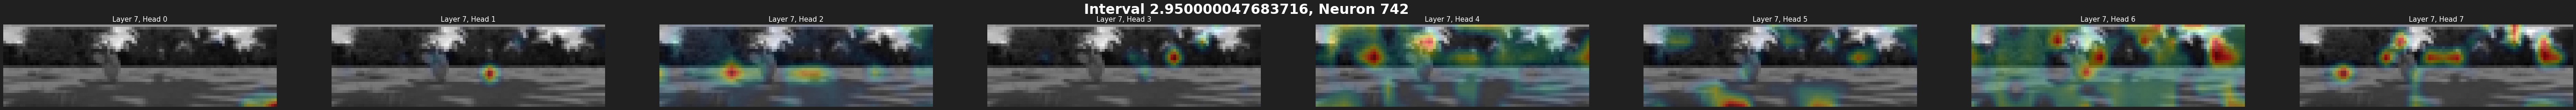

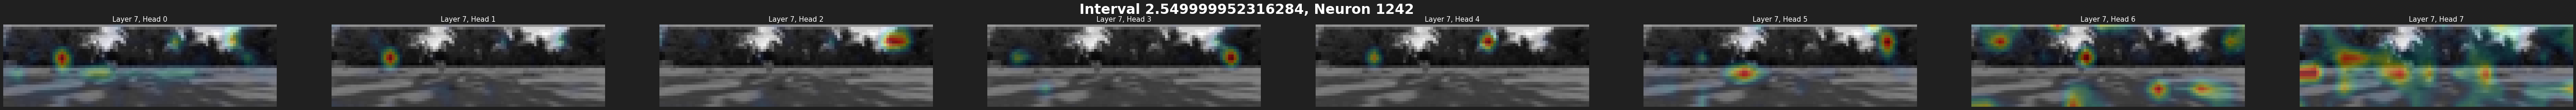

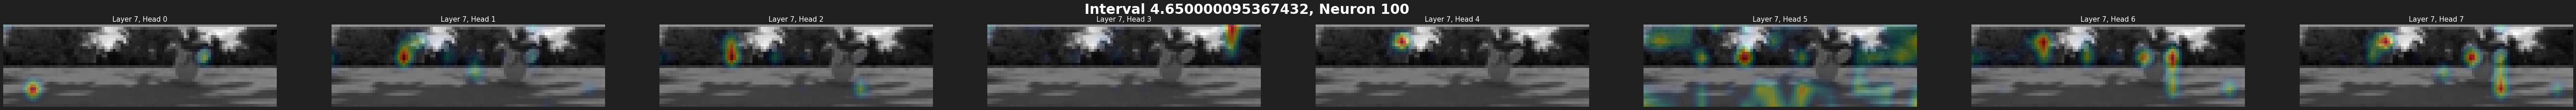

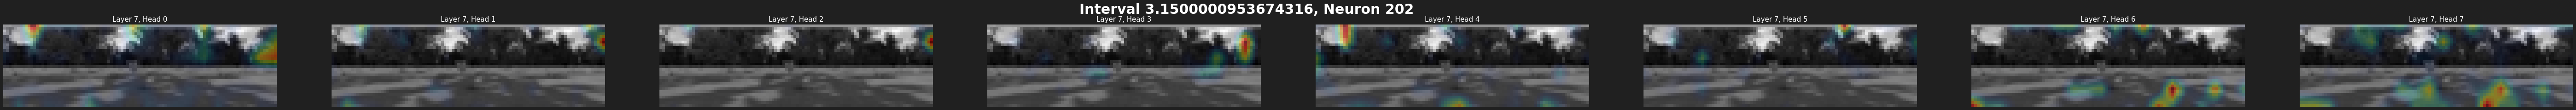

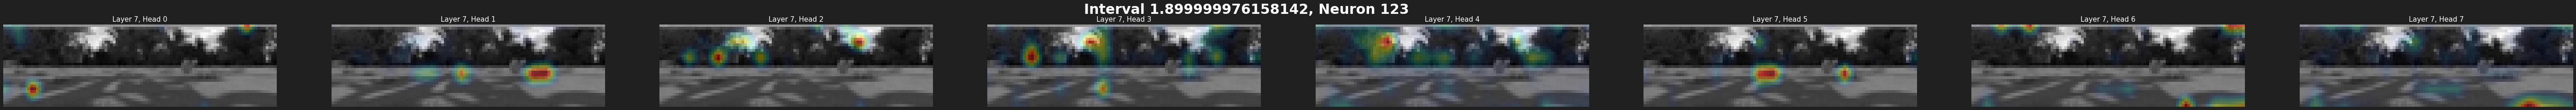

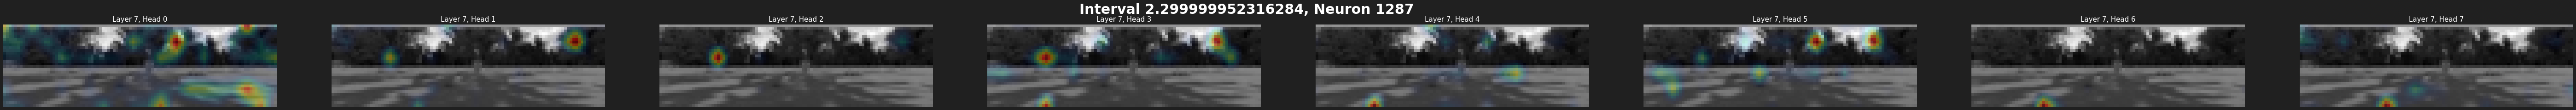

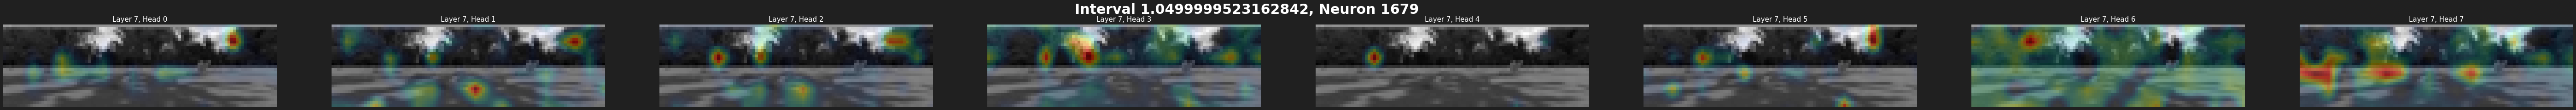

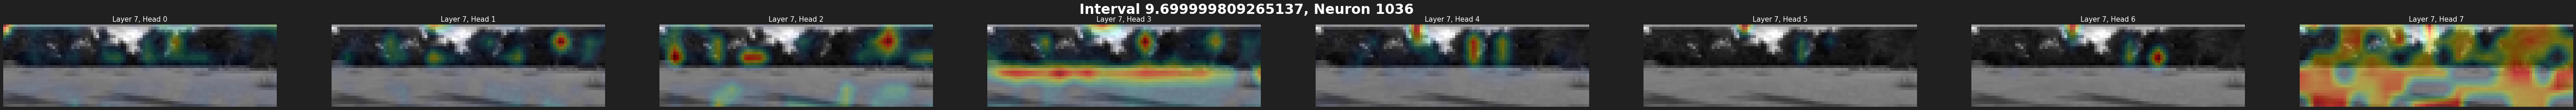

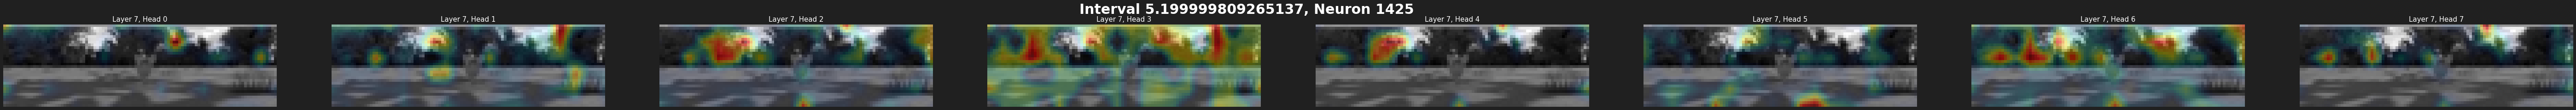

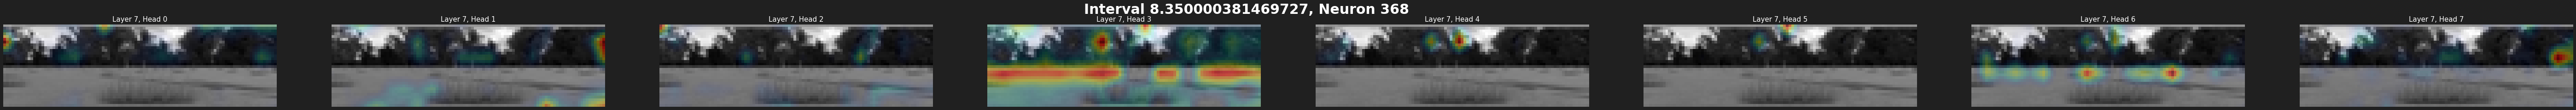

In [76]:
att_data = train_data
att_data = train_data[train_data['Trial'] > 20]


i1, i2 = 6.8, 7.2
att_data = att_data[(att_data['Interval'] > i1) & (att_data['Interval'] < i2)]


att_dataset = train_dataset

loader = DataLoader(att_dataset, shuffle=True, pin_memory=False,
                                  batch_size=1, num_workers=1)
iterable = iter(loader)

max_it = 10
images, attentions = [], []
for it, (x, y) in enumerate(loader):
    if it > max_it:
        break
    _, _, _, = model(x, y)
    print(x['interval'])

    from neuroformer.attentionVis import get_attention
    vis_mod = model.neural_visual_transformer.neural_state_stimulus_blocks
    vis_att = get_attention(vis_mod, mconf.n_stimulus_layers, mconf.block_size)

    from neuroformer.attentionVis import AttentionVis as AV

    ims, atts = AV().plot_stim_att_layer_head(x, mconf, vis_att, h=6, w=20, layer_no=7)
    images.extend(ims)
    attentions.extend(atts)

In [77]:
# from attentionVis import AttentionVis as AV

# AV().plot_stim_att_layer_head(x, mconf, vis_att)

In [78]:
x, y = next(iterable)

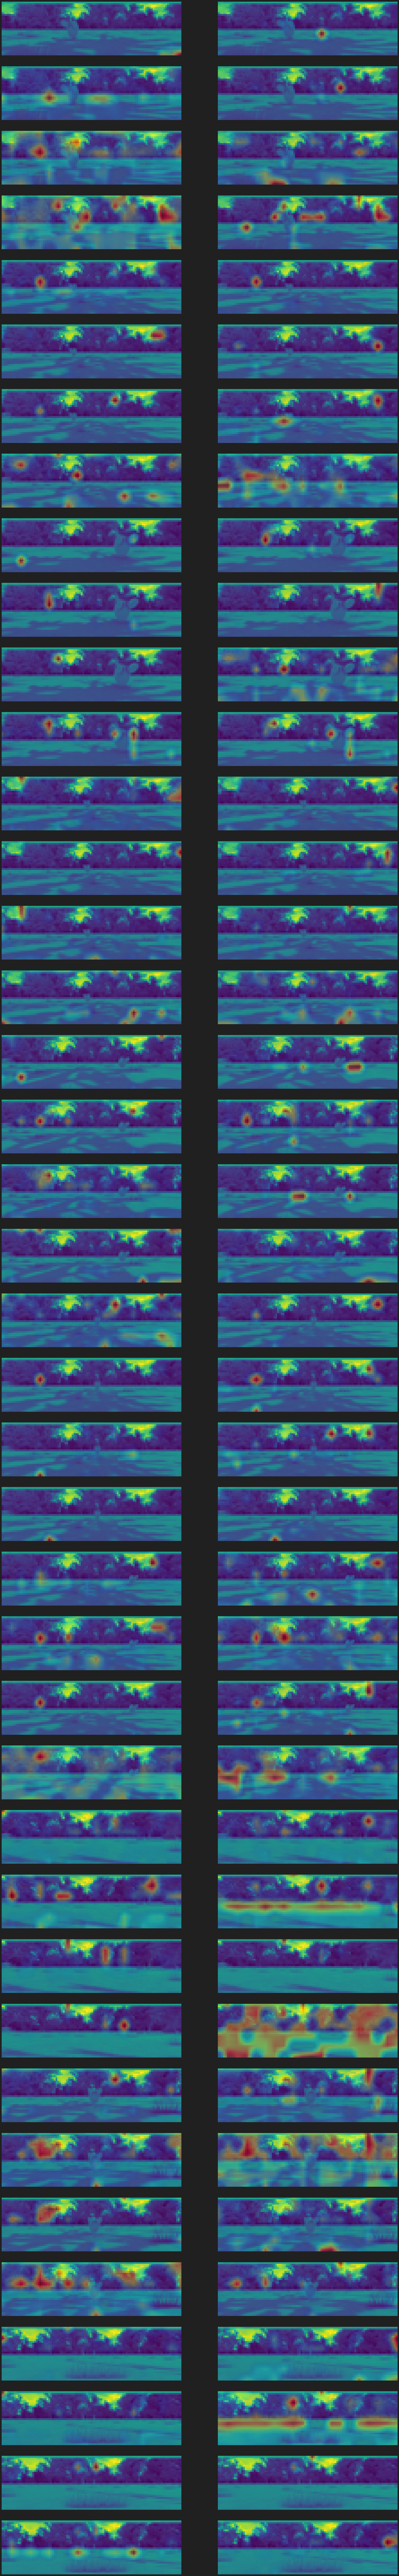

In [79]:
# images, attentions = AV().plot_stim_att_layer_head(x, mconf, vis_att, h=6, w=20, layer_no=7)
ncols = 2
nrows = len(images) // ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(30, 10 * nrows / ncols))
axs = axs.flatten()
for i, (img, att) in enumerate(zip(images, attentions)):
    axs[i].imshow(img)
    AV().heatmap2d(att, ax=axs[i], alpha=0.6, blur=0, clim=None)
    axs[i].axis('off')